# Post-Clustering Deep Dive Analysis

---

1. **Cluster Personas** - Give each cluster a meaningful name
2. **Geographic Analysis** - Where do vulnerable households live?
3. **Spending Patterns** - What drives inflation?
4. **Income Analysis** - How does inflation vary by income?
5. **Policy Insights** - Actionable findings
6. **Interactive Dashboards** - Presentation-ready visualizations

## 1 Setup and Load Data

In [24]:
# Install packages
!pip install -q pandas numpy matplotlib seaborn plotly scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.facecolor'] = 'white'



Libraries loaded!


In [25]:
# Load clustered data
df = pd.read_csv('train_data_with_clusters.csv')

print('DATASET OVERVIEW')
print(f'Total households: {len(df):,}')
print(f'Features: {df.shape[1]}')
print(f'\nCluster distribution:')
print(df['cluster_kmeans'].value_counts().sort_index())

DATASET OVERVIEW
Total households: 40,918
Features: 26

Cluster distribution:
cluster_kmeans
0     6566
1    18565
2    15569
3      218
Name: count, dtype: int64


## 2Analyze Cluster Characteristics

In [26]:
# Calculate statistics for each cluster
cluster_stats = df.groupby('cluster_kmeans').agg({
 'Income': ['mean', 'median'],
 'Family_Size': 'mean',
 'Age_Head': 'mean',
 'Number_Earners': 'mean',
 'Effective_Inflation': ['mean', 'median', 'std']
}).round(3)

print('\nCLUSTER STATISTICS')
display(cluster_stats)


 CLUSTER STATISTICS


Income        Family_Size Age_Head Number_Earners  \
                 mean median        mean     mean           mean   
cluster_kmeans                                                     
0              -0.262 -0.426       0.152   -0.321          0.148   
1               0.498  0.174       0.426   -0.587          0.615   
2              -0.490 -0.617      -0.574    0.844         -0.803   
3               0.773  0.363       0.260   -0.335          0.425   

               Effective_Inflation                
                              mean median    std  
cluster_kmeans                                    
0                            9.720  9.962  4.226  
1                            4.539  4.249  2.177  
2                            5.029  4.754  2.431  
3                            2.838  2.685  0.968

## 3 Create Cluster Personas

In [27]:
# Define cluster names based on YOUR data patterns
cluster_names = {
 0: 'High-Inflation Group',
 1: 'Middle-Income Families',
 2: 'Low-Inflation Group',
 # Add more clusters as needed
}

# Add names to dataframe
df['Cluster_Name'] = df['cluster_kmeans'].map(cluster_names)

print('\nCLUSTER PERSONAS')
for cluster_id in sorted(df['cluster_kmeans'].unique()):
 cluster_data = df[df['cluster_kmeans'] == cluster_id]
 pct = 100 * len(cluster_data) / len(df)

 print(f'\nCluster {cluster_id}: {cluster_names.get(cluster_id, "Unknown")}')
 print(f'Size: {len(cluster_data):,} ({pct:.1f}%)')
 print(f'Avg Income: ${cluster_data["Income"].mean():.2f}')
 print(f'Avg Inflation: {cluster_data["Effective_Inflation"].mean():.2f}%')
 print(f'Family Size: {cluster_data["Family_Size"].mean():.1f}')


 CLUSTER PERSONAS

Cluster 0: High-Inflation Group
Size: 6,566 (16.0%)
Avg Income: $-0.26
Avg Inflation: 9.72%
Family Size: 0.2

Cluster 1: Middle-Income Families
Size: 18,565 (45.4%)
Avg Income: $0.50
Avg Inflation: 4.54%
Family Size: 0.4

Cluster 2: Low-Inflation Group
Size: 15,569 (38.0%)
Avg Income: $-0.49
Avg Inflation: 5.03%
Family Size: -0.6

Cluster 3: Unknown
Size: 218 (0.5%)
Avg Income: $0.77
Avg Inflation: 2.84%
Family Size: 0.3


## 4 Geographic Distribution

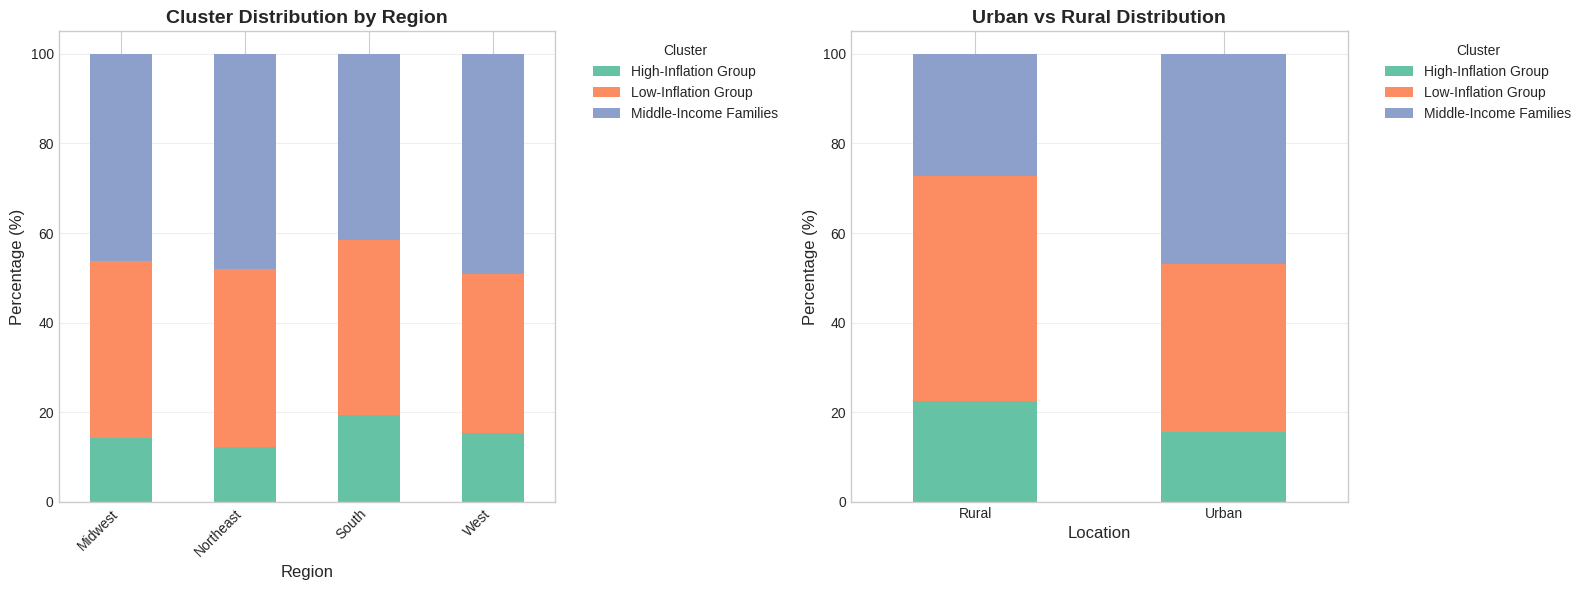

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By region
region_cluster = pd.crosstab(df['Region'], df['Cluster_Name'],
 normalize='index') * 100
region_cluster.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Cluster Distribution by Region',
 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Region', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Urban vs Rural
urban_cluster = pd.crosstab(df['Urban_Rural'], df['Cluster_Name'],
 normalize='index') * 100
urban_cluster.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Urban vs Rural Distribution',
 fontsize=14, fontweight='bold')
axes[1].set_xlabel('Location', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5 Spending Pattern Heatmap

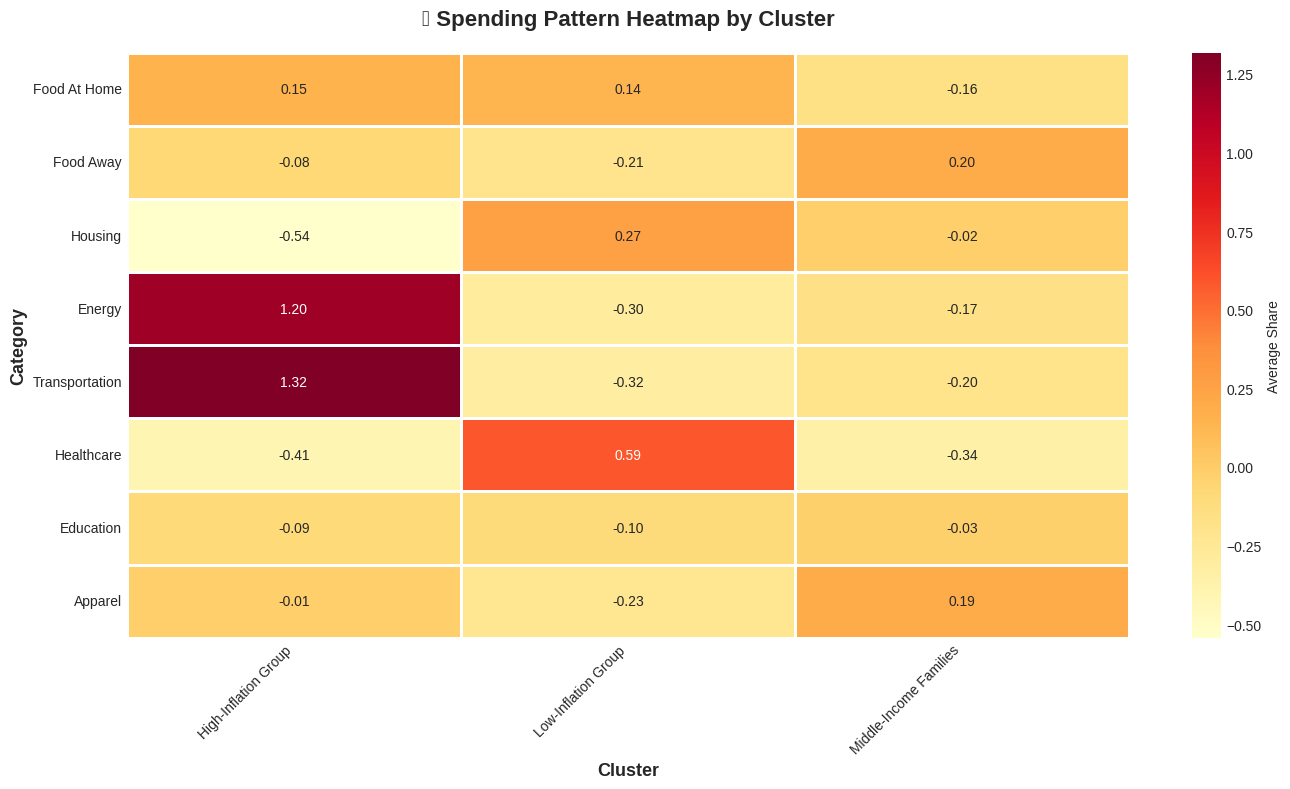

In [29]:
spending_cols = ['Food_at_home_share', 'Food_away_share', 'Housing_share',
 'Energy_share', 'Transportation_share', 'Healthcare_share',
 'Education_share', 'Apparel_share']

spending_by_cluster = df.groupby('Cluster_Name')[spending_cols].mean()

# Clean column names
spending_by_cluster.columns = [col.replace('_share', '').replace('_', ' ').title()
 for col in spending_by_cluster.columns]

plt.figure(figsize=(14, 8))
sns.heatmap(spending_by_cluster.T, annot=True, fmt='.2f', cmap='YlOrRd',
 cbar_kws={'label': 'Average Share'},
 linewidths=1, linecolor='white')
plt.title(' Spending Pattern Heatmap by Cluster',
 fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=13, fontweight='bold')
plt.ylabel('Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6 Inflation by Income Quintile

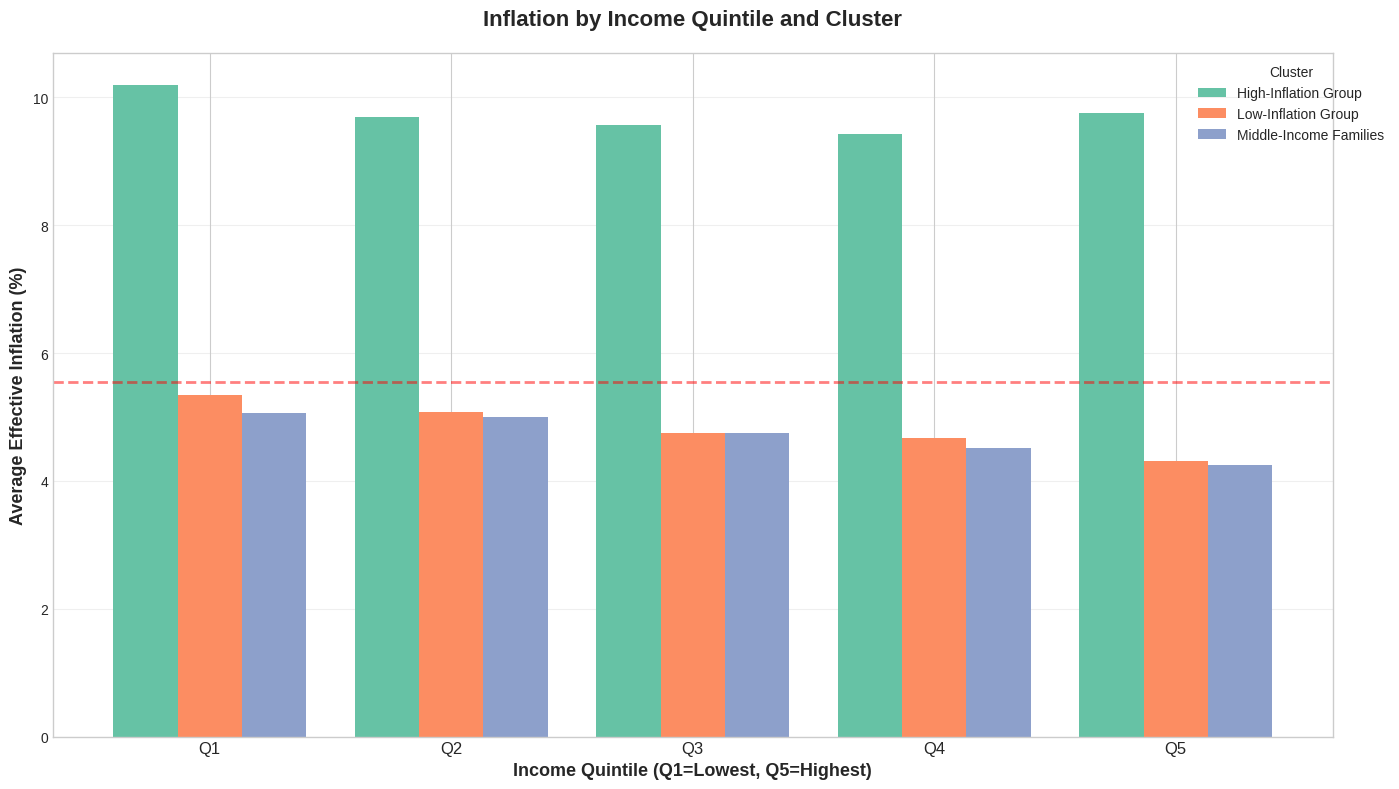


 Inequality Gap: 1.46 percentage points
→ Lower-income face HIGHER inflation (regressive)


In [30]:
inflation_quintile = df.groupby(['Cluster_Name', 'Income_Quintile'])['Effective_Inflation'].mean().unstack()

quintile_order = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
inflation_quintile = inflation_quintile[quintile_order]

fig, ax = plt.subplots(figsize=(14, 8))
inflation_quintile.T.plot(kind='bar', ax=ax, width=0.8)

ax.set_title('Inflation by Income Quintile and Cluster',
 fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Income Quintile (Q1=Lowest, Q5=Highest)',
 fontsize=13, fontweight='bold')
ax.set_ylabel('Average Effective Inflation (%)',
 fontsize=13, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
ax.set_xticklabels(quintile_order, rotation=0, fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=df['Effective_Inflation'].mean(), color='red',
 linestyle='--', linewidth=2, alpha=0.5, label='Overall Avg')

plt.tight_layout()
plt.show()

# Calculate gap
q1_avg = df[df['Income_Quintile'] == 'Q1']['Effective_Inflation'].mean()
q5_avg = df[df['Income_Quintile'] == 'Q5']['Effective_Inflation'].mean()
gap = q1_avg - q5_avg

print(f'\nInequality Gap: {gap:.2f} percentage points')
if gap > 0:
 print('- Lower-income face HIGHER inflation (regressive)')
else:
 print('- Higher-income face HIGHER inflation (progressive)')

## 7 Inflation Distribution by Cluster

In [31]:
fig = px.box(df, x='Cluster_Name', y='Effective_Inflation',
 color='Cluster_Name',
 title='Inflation Distribution by Cluster',
 labels={'Cluster_Name': 'Cluster',
 'Effective_Inflation': 'Effective Inflation (%)'})

fig.add_hline(y=df['Effective_Inflation'].median(),
 line_dash='dash', line_color='red',
 annotation_text='Overall Median')

fig.update_layout(showlegend=False, height=600)
fig.show()

## 8 Vulnerability Analysis

In [32]:
# Calculate vulnerability score (high inflation + low income)
df['Vulnerability_Score'] = (
 (df['Effective_Inflation'] - df['Effective_Inflation'].mean()) /
 df['Effective_Inflation'].std() -
 (df['Income'] - df['Income'].mean()) / df['Income'].std()
)

# Most vulnerable households
most_vulnerable = df.nlargest(1000, 'Vulnerability_Score')

print('TOP 1,000 MOST VULNERABLE HOUSEHOLDS')
print(f'Avg inflation: {most_vulnerable["Effective_Inflation"].mean():.2f}%')
print(f'Avg income: ${most_vulnerable["Income"].mean():.2f}')
print(f'\nMost common cluster: {most_vulnerable["Cluster_Name"].mode()[0]}')
print(f'Most common region: {most_vulnerable["Region"].mode()[0]}')
print(f'Avg family size: {most_vulnerable["Family_Size"].mean():.1f}')

TOP 1,000 MOST VULNERABLE HOUSEHOLDS
Avg inflation: 15.63%
Avg income: $-0.59

Most common cluster: High-Inflation Group
Most common region: South
Avg family size: -0.0


## 9 Policy Recommendations

In [33]:
most_affected_cluster = df.groupby('Cluster_Name')['Effective_Inflation'].mean().idxmax()
most_affected_region = df.groupby('Region')['Effective_Inflation'].mean().idxmax()

print('\nPOLICY RECOMMENDATIONS')

print('\n1 TARGET VULNERABLE GROUPS')
print(f'- Focus on: {most_affected_cluster}')
affected_data = df[df['Cluster_Name']==most_affected_cluster]
print(f'- Avg inflation: {affected_data["Effective_Inflation"].mean():.2f}%')
print(f'- Population: {len(affected_data):,} households')

print('\n2 REGIONAL PRIORITIES')
print(f'- Most affected: {most_affected_region}')
region_data = df[df['Region']==most_affected_region]
print(f'- Avg inflation: {region_data["Effective_Inflation"].mean():.2f}%')

print('\n3 SPENDING PRIORITIES')
top_burdens = most_vulnerable[spending_cols].mean().nlargest(3)
top_burdens.index = [col.replace('_share', '').replace('_', ' ').title()
 for col in top_burdens.index]
for idx, (category, share) in enumerate(top_burdens.items(), 1):
 print(f'{idx}. {category}: {share:.2f} budget share')



 POLICY RECOMMENDATIONS

1️ TARGET VULNERABLE GROUPS
   • Focus on: High-Inflation Group
   • Avg inflation: 9.72%
   • Population: 6,566 households

2️ REGIONAL PRIORITIES
   • Most affected: South
   • Avg inflation: 5.69%

3️ SPENDING PRIORITIES
   1. Transportation: 2.22 budget share
   2. Energy: 1.86 budget share
   3. Food At Home: 0.22 budget share



## Summary

In [36]:
n_clusters = df['cluster_kmeans'].nunique()

print(f'Identified {n_clusters} distinct clusters')
print(f'Analyzed {len(df):,} households')
print(f'Found {len(most_vulnerable):,} vulnerable households')
print(f'Inequality gap: {gap:.2f} percentage points')

Identified 4 distinct clusters
Analyzed 40,918 households
Found 1,000 vulnerable households
 Inequality gap: 1.46 percentage points
